# Punto 1

## Punto 1.1 <a id="punto-1-1"></a>

In [222]:
import numpy as np
import pandas as pd


df = pd.read_csv(r"../data/raw/casas_dev.csv") 

df.sample(5, random_state=42)


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
70,872.0,sqft,0,0,11.0,630.0,40.718433,-74.008699,2.0
827,1076.0,sqft,0,0,7.0,772.0,40.707037,-73.998823,3.0
231,137.0,m2,0,0,10.0,214.0,-34.550223,-58.391268,4.0
588,775.0,sqft,1,1,10.0,751.0,40.726223,-74.043929,2.0
39,154.0,m2,1,0,16.0,273.0,-34.563525,-58.347365,4.0


In [223]:

df.describe(include='all')


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,533.598889,NaN,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,502.318230,NaN,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,NaN,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,93.000000,NaN,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,164.500000,NaN,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,980.000000,NaN,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000


Algo que es particular resaltar es que la feature ```area_units``` no tiene sentido que se mantenga. Podemos realizar una conversión y eliminar está feature.

Convertimos la feature ```sqft``` a ```m2``` y eliminamos la columna ```area_units```

In [224]:
df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'

df = df.drop('area_units', axis=1)

df.describe(include='all')

,area,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
mean,94.794747,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,30.220560,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,74.000000,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,92.995903,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,111.264314,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000
max,237.000000,1.000000,1.000000,20.000000,1992.000000,40.764550,-58.295919,5.000000


Hacemos un análisis de las features que contienen NaNs.

In [225]:
from utils import get_nan_features

nan_features = get_nan_features(df)


print("Features con valores nulos y su cantidad de valores nulos: ", nan_features.items())


Features con valores nulos y su cantidad de valores nulos:  dict_items([('age', 130), ('rooms', 72)])


Observamos que las features con ```NaNs``` son ```age``` y ```room```.

Obtenemos la distribucion empirica de la feature ```rooms``` y de ```age```

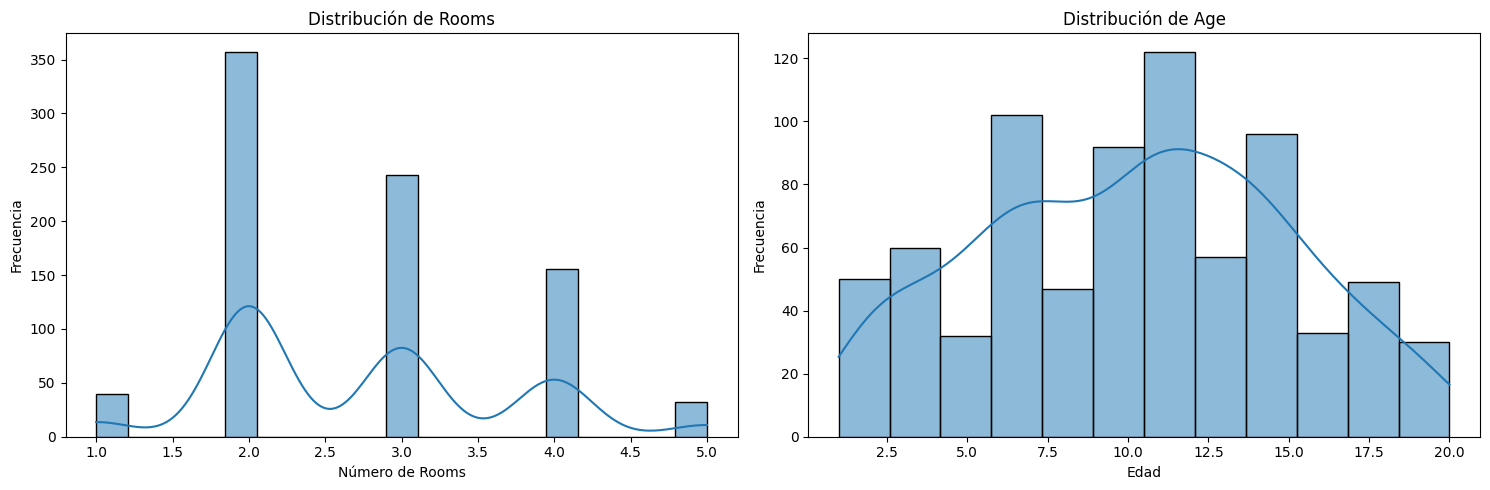

In [226]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['rooms'], kde=True, ax=axes[0])
axes[0].set_title('Distribución de Rooms')
axes[0].set_xlabel('Número de Rooms')
axes[0].set_ylabel('Frecuencia')

sns.histplot(df['age'], kde=True, ax=axes[1])
axes[1].set_title('Distribución de Age')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Observamos que la media de ```roooms``` es ```2.737``` y que la media de ```age``` es ```10.212```. Podemos reemplazar en las muestras (filas) que tienen ```NaNs``` con la media. Esto es un proceso válido ya que al reemplazar los NaNs con la media, la variable conserva su escala original (no se generan valores fuera de rango ni se produce un sesgo), lo que ayuda a mantener la consistencia de la información que aporta esa variable.

Otra solución sería utilizar un modelo NO LINEAL para predecir estas features (PREGUNTAR SI SE PUEDE). 

In [227]:

features_to_impute = ['rooms', 'age']


for feature in features_to_impute:

    mean_value = df[feature].mean()
    
    df[feature] = df[feature].fillna(mean_value)
    
    print(f'Imputando en {feature} con la media: {mean_value}')
    

print(df.head())

Imputando en rooms con la media: 2.7379227053140096
Imputando en age con la media: 10.212987012987012
         area  is_house  has_pool   age  price        lat        lon  rooms
0   58.993405         1         0  18.0  546.0  40.679064 -74.007844    2.0
1  102.007494         0         0   9.0  759.0  40.712839 -73.967750    3.0
2   61.966301         0         0   7.0  464.0  40.669863 -74.029414    2.0
3  127.000000         1         1  16.0  251.0 -34.600437 -58.415266    4.0
4  128.020334         0         0   8.0  963.0  40.722322 -73.983229    4.0


Guardamos el dataframe en un CSV.

In [228]:
df.to_csv(r"../data/processed/casas_dev.csv", index=False)

## Punto 1.2 <a id="punto-1-2"></a>



<div style="padding: 10px; border-radius: 5px;">
    <p>
        Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar
        la relación entre las variables. Para esto, es útil el comando <code>pairplot</code>. 
        ¿Qué conclusiones puede extraer a simple vista acerca de las relaciones entre las variables? 
        Se permite la creación de gráficos adicionales que considere relevantes.
    </p>
</div>


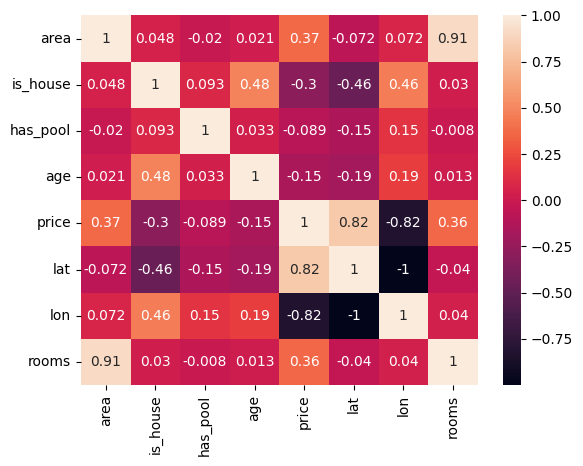

,area,is_house,has_pool,age,price,lat,lon,rooms
area,1.000000,0.047767,-0.020012,0.020607,0.371862,-0.071974,0.071787,0.907964
is_house,0.047767,1.000000,0.093175,0.482947,-0.298412,-0.459865,0.459664,0.029574
has_pool,-0.020012,0.093175,1.000000,0.033317,-0.088624,-0.146234,0.146399,-0.007955
age,0.020607,0.482947,0.033317,1.000000,-0.149007,-0.194795,0.194773,0.013094
price,0.371862,-0.298412,-0.088624,-0.149007,1.000000,0.822490,-0.822537,0.359635
lat,-0.071974,-0.459865,-0.146234,-0.194795,0.822490,1.000000,-0.999992,-0.040040
lon,0.071787,0.459664,0.146399,0.194773,-0.822537,-0.999992,1.000000,0.039892
rooms,0.907964,0.029574,-0.007955,0.013094,0.359635,-0.040040,0.039892,1.000000


In [229]:
import seaborn as sns 


# show the correlation matrix
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

corr

Observamos que la variable **area** presenta una correlación muy alta de 0.91 con **rooms**, lo que es totalmente coherente, ya que a medida que aumenta la cantidad de habitaciones, la superficie total de la propiedad tiende a crecer. Además, la **latitud (lat)** muestra una fuerte correlación positiva de 0.82 con **price**, lo que sugiere que las propiedades ubicadas en zonas con mayor latitud tienden a tener precios más altos; en contraposición, la **longitud (lon)** tiene una correlación negativa de -0.82 con **price**, lo que indica que en las áreas donde la longitud es mayor, los precios son más bajos. Esto podría interpretarse como que existen zonas geográficas diferenciadas, donde la posición en el mapa influye significativamente en el valor de la propiedad. 

Por otro lado, se observa una correlación moderada de 0.48 entre **is_house** y **age**, lo que sugiere que las casas (frente a otros tipos de propiedades) tienden a ser más antiguas. Asimismo, **is_house** se relaciona moderadamente con las coordenadas: presenta una correlación de -0.46 con **lat** y de 0.46 con **lon**, lo que puede indicar que las casas se concentran en áreas geográficas específicas distintas a aquellas de otros inmuebles. 

Finalmente, resulta destacable la casi perfecta correlación negativa de -1.0 entre **lat** y **lon**, lo que implica que, dentro del rango de datos, a medida que aumenta la latitud, la longitud disminuye de forma casi lineal, reflejando probablemente una distribución geográfica particular de las propiedades. Estos patrones nos ayudan a entender que la ubicación y el tipo de inmueble son determinantes importantes en la configuración del precio y otras características de las viviendas en el dataset.

puedo hacer lo que decia robbie de has_pool * is_house etc.

Podriamos clasificar las casas por zonas (clusters)

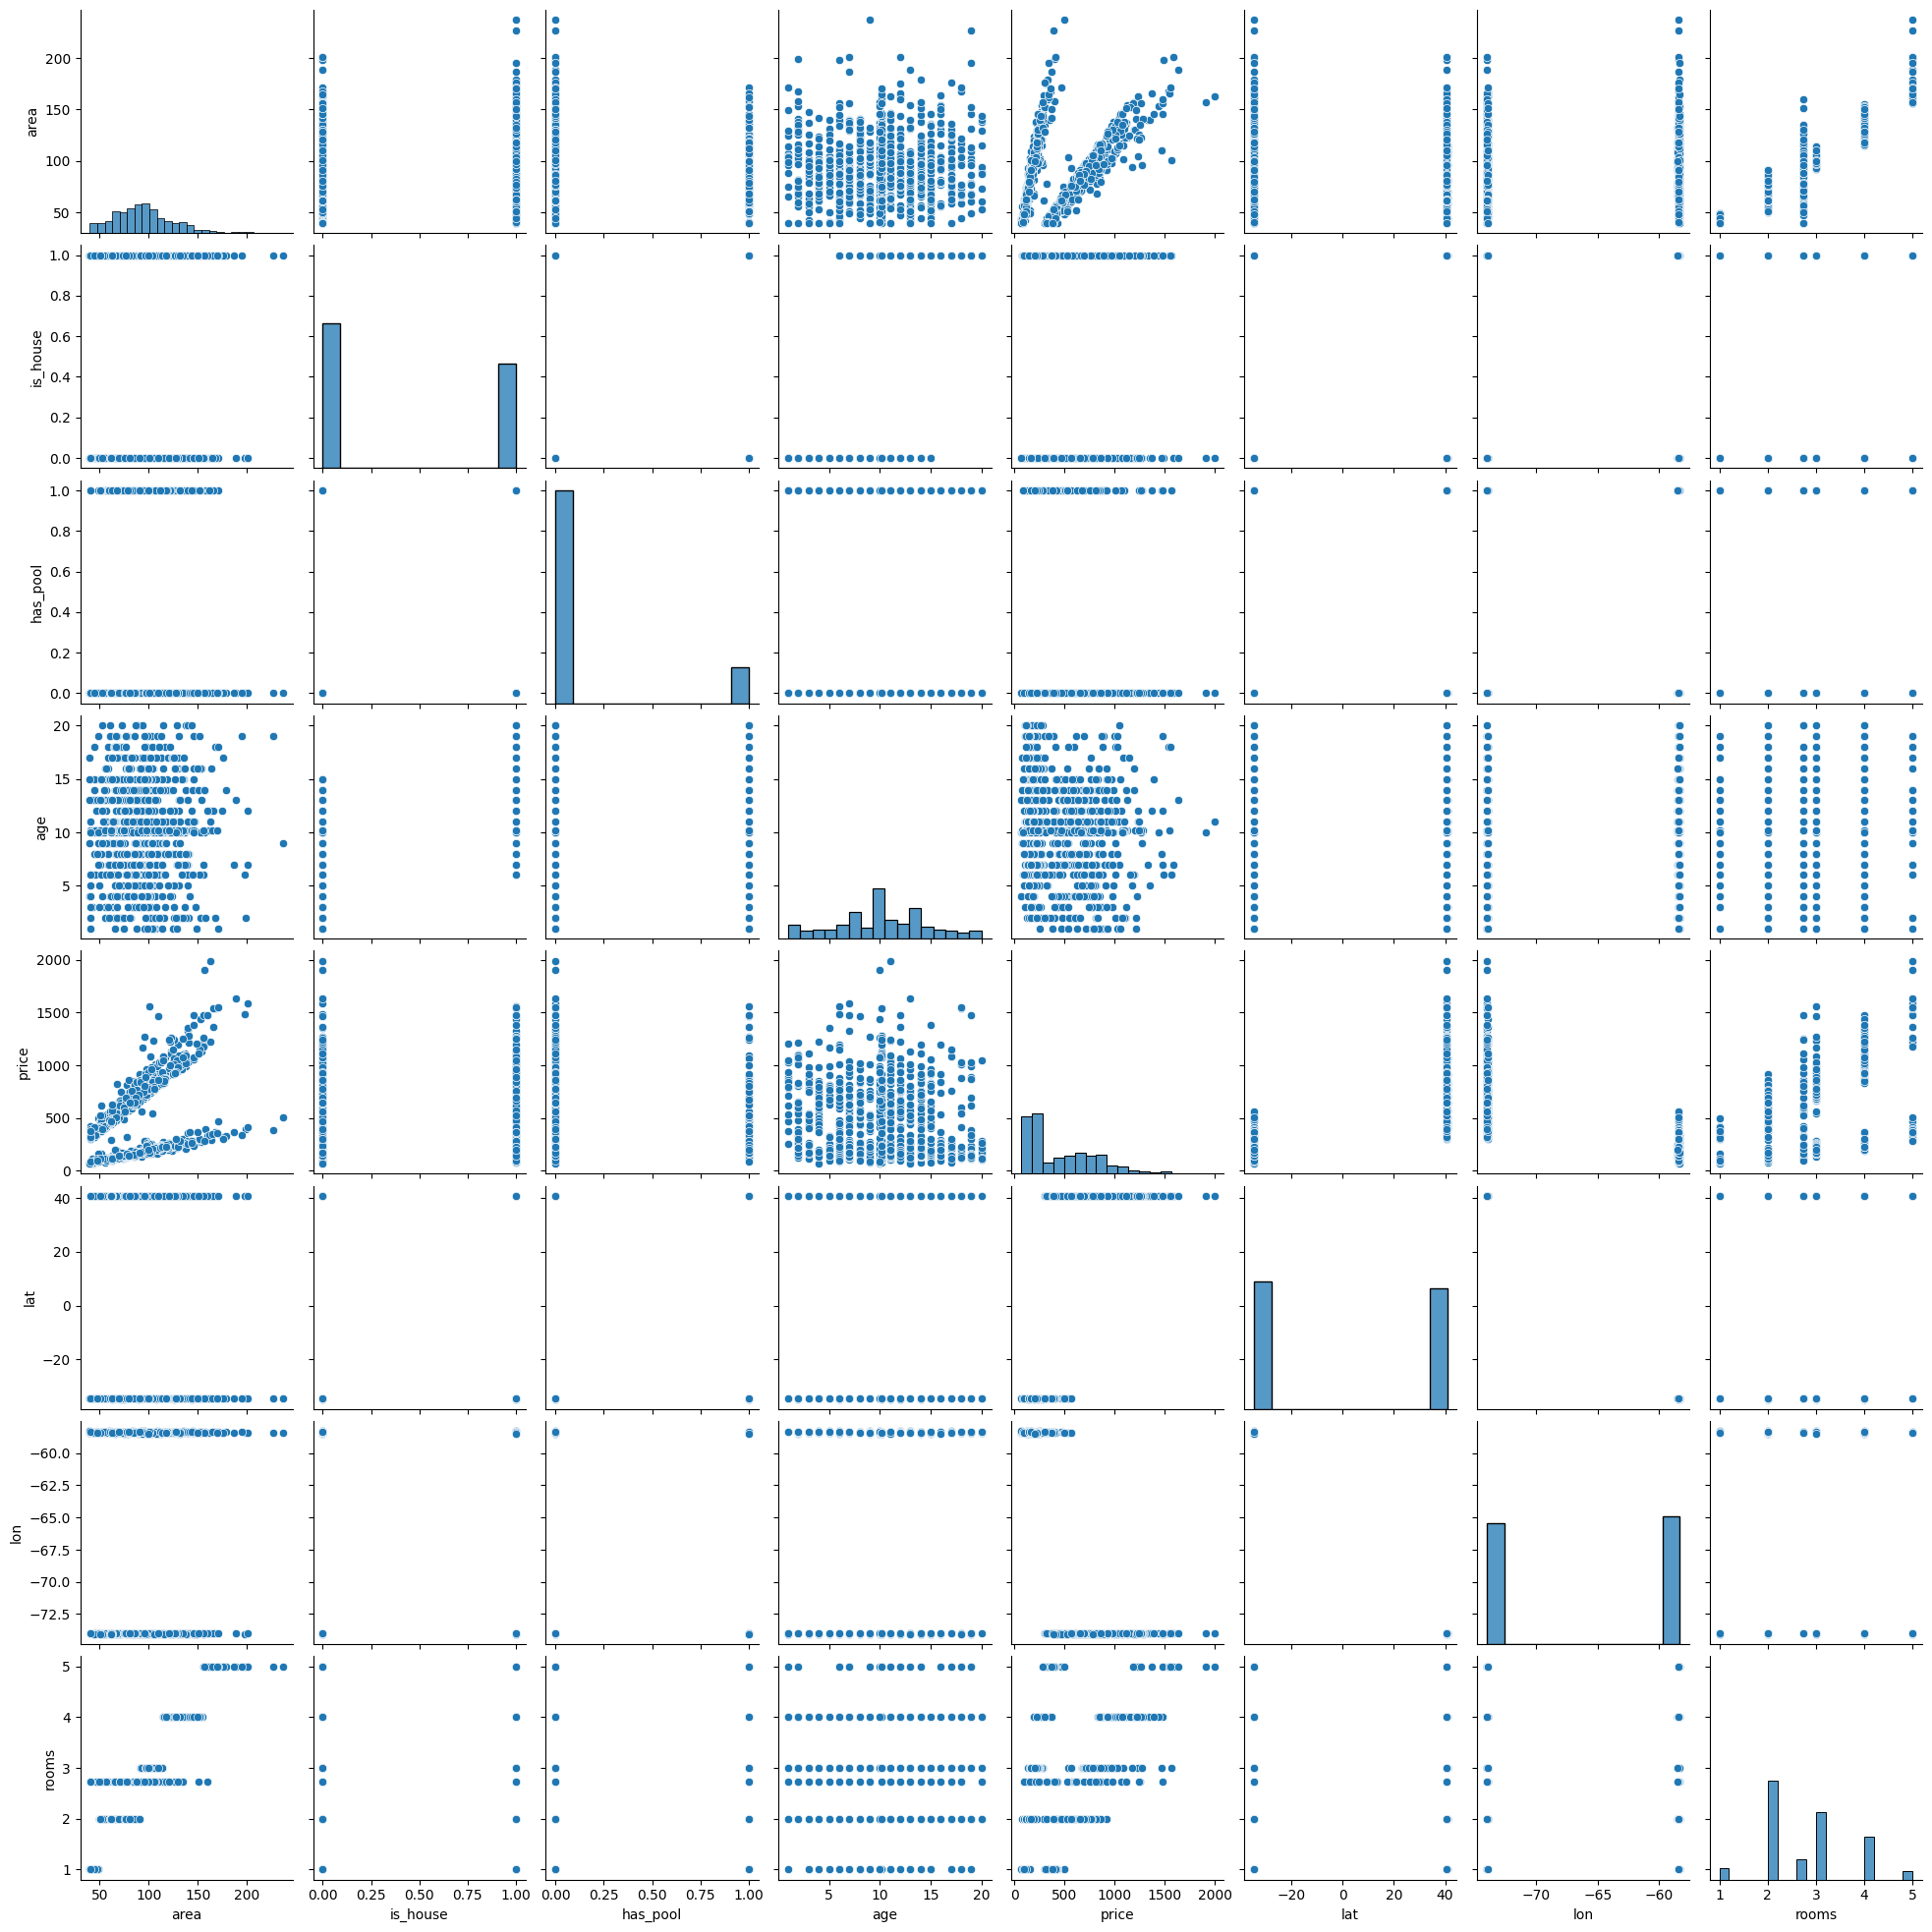

In [230]:
sns.pairplot(df)
plt.show()

In [231]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# # Crear una figura con subplots
# fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# # 1. Relación entre área y precio
# sns.scatterplot(x='area', y='price', data=df, ax=axes[0, 0])
# axes[0, 0].set_title('Área vs Precio')
# axes[0, 0].set_xlabel('Área')
# axes[0, 0].set_ylabel('Precio')

# # 2. Relación entre área y rooms
# sns.scatterplot(x='area', y='rooms', data=df, ax=axes[0, 1])
# axes[0, 1].set_title('Área vs Rooms')
# axes[0, 1].set_xlabel('Área')
# axes[0, 1].set_ylabel('Rooms')

# # 3. Relación entre rooms y precio
# sns.scatterplot(x='rooms', y='price', data=df, ax=axes[1, 0])
# axes[1, 0].set_title('Rooms vs Precio')
# axes[1, 0].set_xlabel('Rooms')
# axes[1, 0].set_ylabel('Precio')

# # 4. Relación entre has_pool y precio: Usamos boxplot porque has_pool es binaria
# sns.boxplot(x='has_pool', y='price', data=df, ax=axes[1, 1])
# axes[1, 1].set_title('Has Pool vs Precio')
# axes[1, 1].set_xlabel('Has Pool')
# axes[1, 1].set_ylabel('Precio')

# # 5. Relación entre age y precio
# sns.scatterplot(x='age', y='price', data=df, ax=axes[2, 0])
# axes[2, 0].set_title('Age vs Precio')
# axes[2, 0].set_xlabel('Age')
# axes[2, 0].set_ylabel('Precio')

# fig.delaxes(axes[2, 1])

# plt.tight_layout()
# plt.show()

## Punto 1.3 <a id="punto-1-3"></a>


Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train)
y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y
validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar
los datos para lograr un mejora el condicionamiento numérico de los algortmos de
aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá
invertir la normalización para volver a las escalas originales.

In [232]:

from models.regression.linear_regressor import LinearRegressor
from models.regression.polinomial_regressor import PolinomialRegressor
from models.regression.data import split_test_train_with_label, split_test_train_without_label

df = pd.read_csv(r"../data/processed/casas_dev.csv")

X = df.drop('price', axis=1)
y = df['price']

y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X, y, test_size=0.2, random_state=12)


### Punto 2?

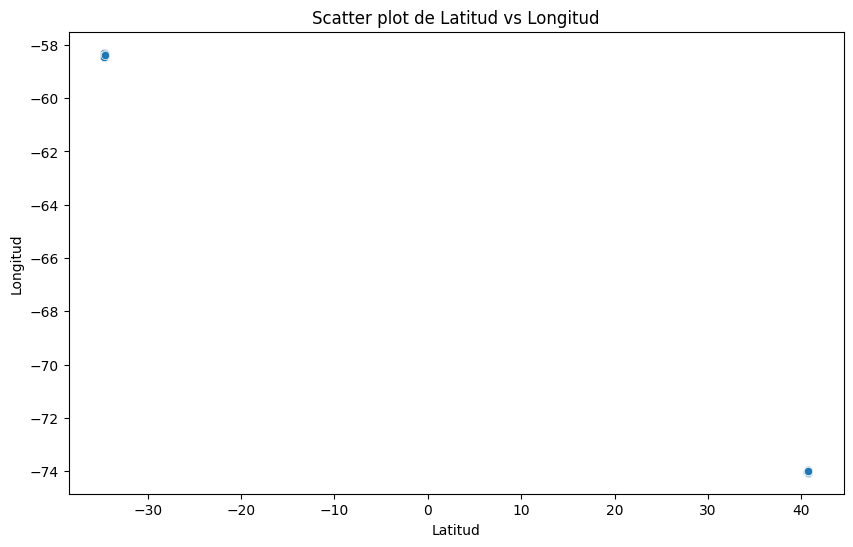

In [233]:
# scatter plot de 'lat' vs 'lon'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='lat', y='lon')
plt.title('Scatter plot de Latitud vs Longitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

# Punto 2

### Todas las features (menos price)

In [234]:
df = pd.read_csv(r"../data/processed/casas_dev.csv")

#### Pseudo Inversa

In [235]:

X = df.drop('price', axis=1)
y = df['price']

#apply log to the price
y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X, y, test_size=0.2, random_state=12)


model_inv = LinearRegressor()

model_inv.fit(X_train, y_train)

mse = model_inv.mse_score(X_test, y_test)
r2_score = model_inv.r2_score(X_test, y_test)

print("Mean Squared Error:", mse)
print("R2 Score:", r2_score)

model_inv.print_coefficients(metric="R2")



Mean Squared Error: 0.012484859021654289
R2 Score: 0.979280664628018
Método: pseudo_inverse
Intercept: -5.9023

Coeficientes:
------------------------------
area            | +0.0098
is_house        | +0.1027
has_pool        | +0.1173
age             | -0.0080
lat             | -0.0144
lon             | -0.1641
rooms           | +0.0215


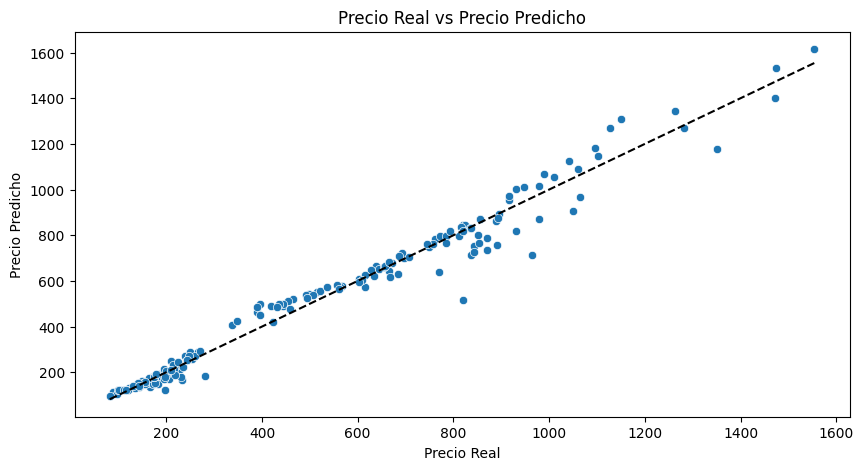

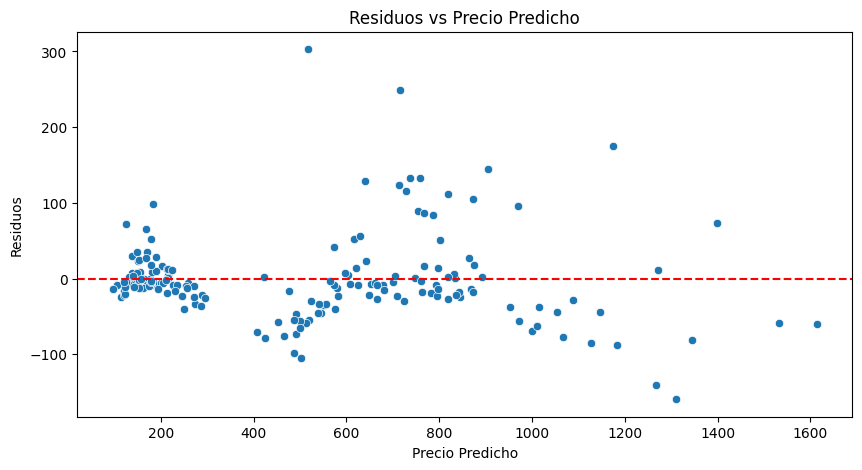

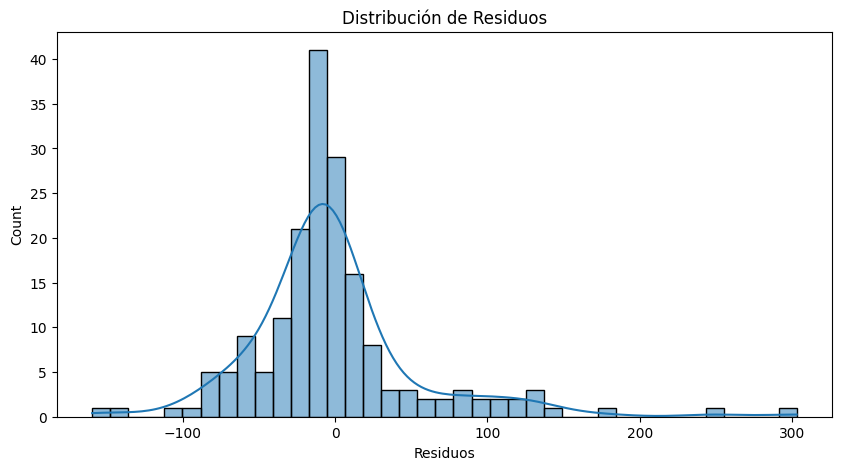

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.exp(model_inv.predict(X_test))
y_true = np.exp(y_test)

# real vs prediccion precio
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_true, y=y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')  # add ideal line
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Precio Real vs Precio Predicho')
plt.show()

# scatter residuos
plt.figure(figsize=(10, 5))
residuals = y_true - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Precio Predicho')
plt.ylabel('Residuos')
plt.title('Residuos vs Precio Predicho')
plt.show()

# residuos distrib.
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de Residuos')
plt.show()

#### TODO: PREGNTAR SI HACE FALTA PONER EXPONENCIAL

#### TODO: Preguntar si puedo normalizar para un caso y para otro NO, ya que el modelo sin normalizar me anda PARA EL ROTO

#### Gradient Descent

In [237]:
df = pd.read_csv(r"../data/processed/casas_dev.csv")
df['price'] = np.log(df['price'])

# normalizar solo las features (excluyendo la columna transformada)
X = df.drop('price', axis=1)
X = (X - X.mean()) / X.std()
y = df['price']
y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X, y, test_size=0.2, random_state=12)

model_gd = LinearRegressor()

model_gd.fit(X_train, y_train, method='gradient_descent', learning_rate=0.01, epochs=1000)


mse = model_gd.mse_score(X_test, y_test)
r2_score = model_gd.r2_score(X_test, y_test)

print("Mean Squared Error:", mse)
print("R2 Score:", r2_score)


model_gd.print_coefficients(metric="R2")


Mean Squared Error: 0.0004918706775173843
R2 Score: 0.9721359564621557
Método: gradient_descent
Intercept: 1.7547

Coeficientes:
------------------------------
area            | +0.0423
is_house        | +0.0044
has_pool        | +0.0069
age             | -0.0029
lat             | +0.0623
lon             | -0.0624
rooms           | +0.0124
Convergencia: Sí
Iteraciones: 303/1000


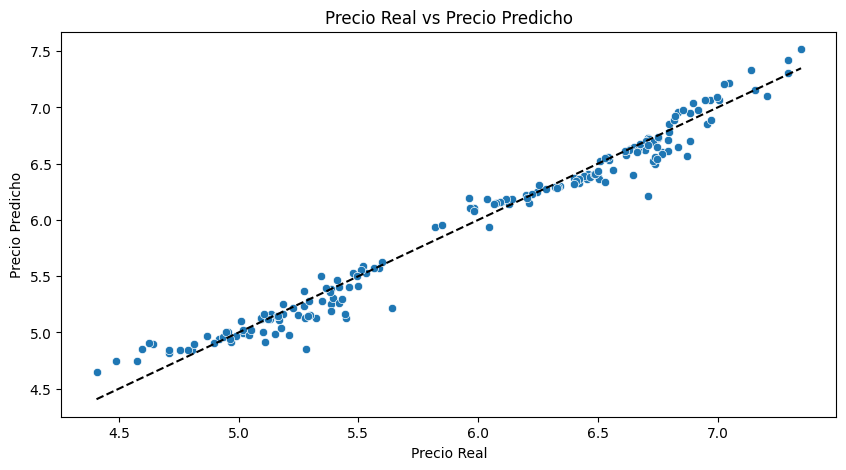

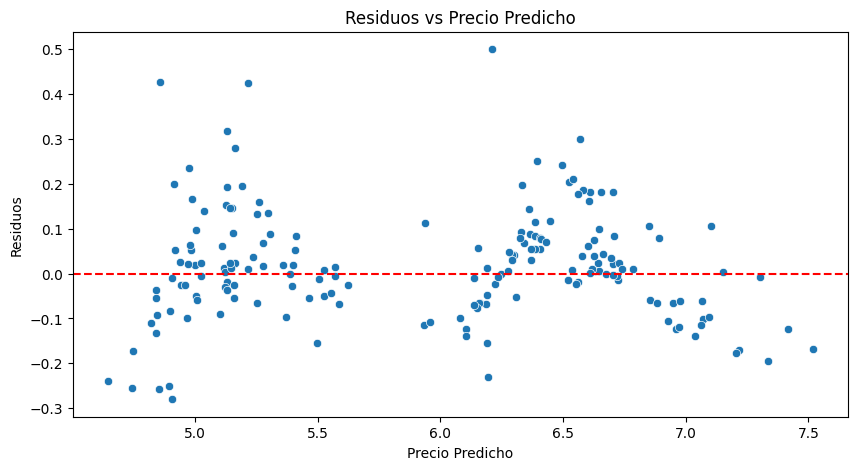

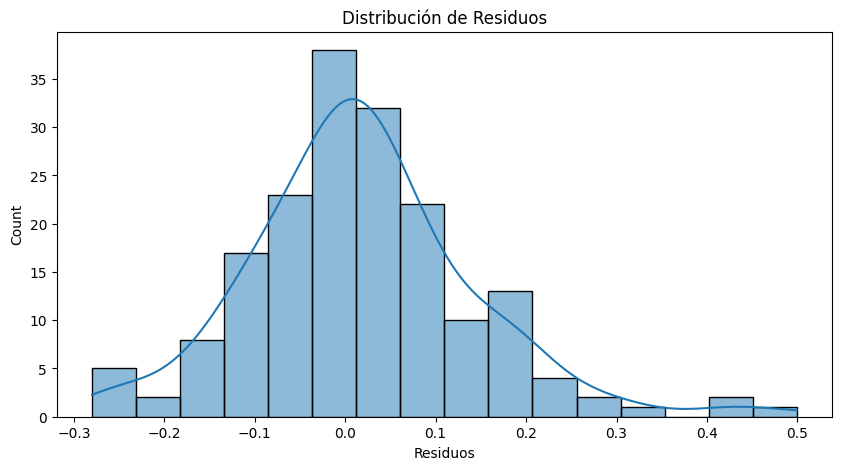

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.exp(model_gd.predict(X_test))
y_true = np.exp(y_test)

# real vs prediccion precio
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_true, y=y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')  # add ideal line
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Precio Real vs Precio Predicho')
plt.show()

# scatter residuos
plt.figure(figsize=(10, 5))
residuals = y_true - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Precio Predicho')
plt.ylabel('Residuos')
plt.title('Residuos vs Precio Predicho')
plt.show()

# residuos distrib.
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de Residuos')
plt.show()

### 1 feature


Pseudo Inversa

In [239]:

X = df.drop('price', axis=1)
y = df['price']

#apply log to the price
y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X[["area"]], y, test_size=0.2, random_state=12)


model_inv = LinearRegressor()

model_inv.fit(X_train, y_train)

mse = model_inv.mse_score(X_test, y_test)
r2_score = model_inv.r2_score(X_test, y_test)

print("Mean Squared Error:", mse)
print("R2 Score:", r2_score)

model_inv.print_coefficients(metric="R2")



Mean Squared Error: 0.015752681467348404
R2 Score: 0.10762437708339445
Método: pseudo_inverse
Intercept: 1.6182

Coeficientes:
------------------------------
area            | +0.0014


Gradient descent


In [240]:
df = pd.read_csv(r"../data/processed/casas_dev.csv")
df['price'] = np.log(df['price'])

# normalizar solo las features (excluyendo la columna transformada)
X = df.drop('price', axis=1)
X = (X - X.mean()) / X.std()
y = df['price']
y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X[["rooms"]], y, test_size=0.2, random_state=12)

model_gd = LinearRegressor()

model_gd.fit(X_train, y_train, method='gradient_descent', learning_rate=0.01, epochs=1000)


mse = model_gd.mse_score(X_test, y_test)
r2_score = model_gd.r2_score(X_test, y_test)

print("Mean Squared Error:", mse)
print("R2 Score:", r2_score)


model_gd.print_coefficients(metric="R2")


Mean Squared Error: 0.016248299311698765
R2 Score: 0.07954805982290292
Método: gradient_descent
Intercept: 1.7502

Coeficientes:
------------------------------
rooms           | +0.0436
Convergencia: Sí
Iteraciones: 293/1000


# Punto 3

## Punto 3.1

# Punto 4

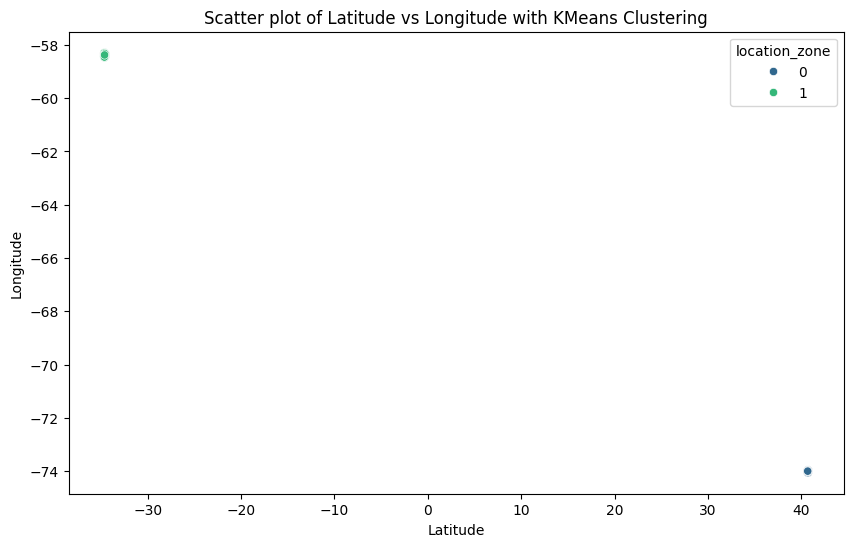

In [241]:
import numpy as np
from models.clustering.kmeans import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Convert DataFrame columns to numpy array
X = df[['lat', 'lon']].to_numpy()

# Create KMeans object
kmeans = KMeans(n_clusters=2)

# Train the model
kmeans.fit(X)

# Get cluster labels
df['location_zone'] = kmeans.predict(X)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='lat', y='lon', hue='location_zone', palette='viridis')
plt.title('Scatter plot of Latitude vs Longitude with KMeans Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()